In [2]:
import numpy as np
import matplotlib.pyplot as plt

# %matplotlib inline
from astropy.table import Table
import pickle as pkl
from pathlib import Path
import pandas
from astropy.io import fits

In [3]:
from clmm import Cosmology

cosmo = Cosmology(H0=70.0, Omega_dm0=0.27 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

The cluster and source galaxy files are generated from the CosmoDC2 processed through TXPipe to test the coordinate system.

In [4]:
cluster = pandas.read_pickle('./data_coords/test_cluster.pkl')

In [5]:
cluster_z = cluster['redshift']  # Cluster redshift
cluster_ra = cluster['ra']  # Cluster Ra in deg
cluster_dec = cluster['dec']

In [6]:
source = np.genfromtxt('./data_coords/test_source.txt',names=True)

In [7]:
gal_ra = source['ra']
gal_dec = source['dec']
gal_e1 = source['e1']
gal_e2 = source['e2']
gal_z = source['zmean']
gal_id = np.arange(len(source['ra']))

In [8]:
import clmm
import clmm.dataops as da
from clmm.utils import convert_units

# Create a GCData with the galaxies.
galaxies = clmm.GCData(
    [gal_ra, gal_dec, gal_e1, gal_e2, gal_z, gal_id], names=["ra", "dec", "e1", "e2", "z", "id"]
)

In [9]:
# Create a GalaxyCluster.
cluster = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec, cluster_z, galaxies)

# Convert elipticities into shears for the members.
cluster.compute_tangential_and_cross_components(coordinate_system='sky')
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    bins=da.make_bins(0.1, 3.0, 15, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']


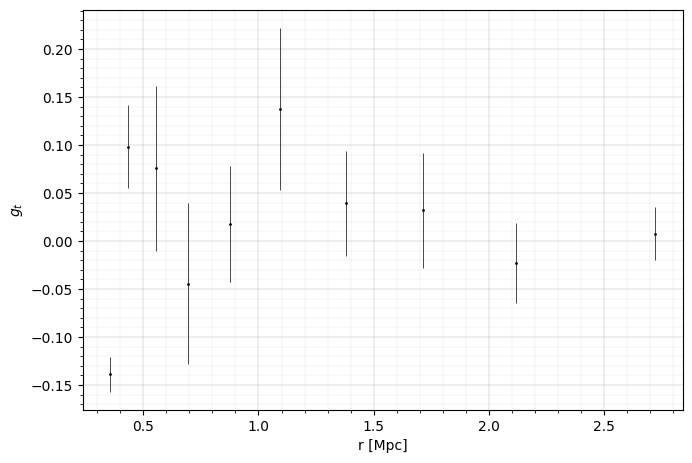

In [10]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    c="k",
    **errorbar_kwargs
)
ax.set_xlabel("r [Mpc]", fontsize=10)
ax.set_ylabel(r"$g_t$", fontsize=10)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.show()

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']


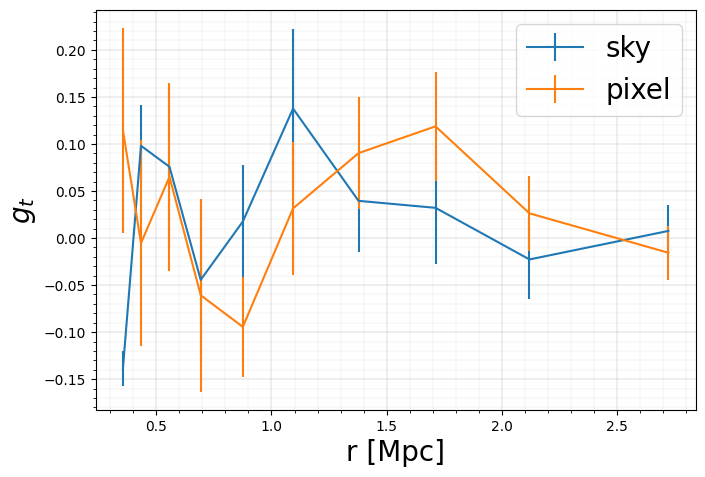

In [11]:
cluster2 = clmm.GalaxyCluster("Name of cluster", cluster_ra, cluster_dec, cluster_z, galaxies)
cluster2.compute_tangential_and_cross_components(coordinate_system='pixel')
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster2.galcat["theta"], "radians", "Mpc", cluster2.z, cosmo)

cluster2.make_radial_profile(
    bins=da.make_bins(0.1, 3.0, 15, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    label='sky'   
)
ax.errorbar(
    cluster2.profile["radius"],
    cluster2.profile["gt"],
    cluster2.profile["gt_err"],
    label='pixel'
)
ax.set_xlabel("r [Mpc]", fontsize=20)
ax.set_ylabel(r"$g_t$", fontsize=20)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.legend(fontsize=20)
plt.show()

The cluster and source catalogs are available at https://github.com/oguri/wlcluster_tutorial (provided by Masamune Oguri). The coordinate system is pixel.

In [12]:
clusters = ['a1703', 'gho1320', 'sdss0851', 'sdss1050', 'sdss1138', 'sdss1226', 'sdss1329', 'sdss1531']

zl_all = {'a1703': 0.277, 'gho1320': 0.308, 'sdss0851': 0.370, 'sdss1050': 0.60, 'sdss1138': 0.451, 'sdss1226': 0.435, 'sdss1329': 0.443, 'sdss1531': 0.335}

ra_cl_all = {'a1703': 198.771833, 'gho1320': 200.703208, 'sdss0851': 132.911917, 'sdss1050': 162.666250, 'sdss1138': 174.537292, 'sdss1226': 186.712958, 'sdss1329': 202.393708, 'sdss1531':  232.794167}

dec_cl_all = {'a1703': 51.817389, 'gho1320': 31.654944, 'sdss0851': 33.518361, 'sdss1050': 0.285306, 'sdss1138': 27.908528, 'sdss1226': 21.831194, 'sdss1329': 22.721167, 'sdss1531':  34.240278}

In [13]:
cname   = 'a1703'

# cluster redshift
zl      = zl_all.get(cname)

# coordinates of the cluster center
ra_cl   = ra_cl_all.get(cname)
dec_cl  = dec_cl_all.get(cname)

# fix source redshift to 1.0
zs = 1.0

In [15]:
rfile = './data_coords/data_oguri/shear_' + cname + '.dat'
data = np.loadtxt(rfile, comments = '#')

ra  = data[:, 0]
dec = data[:, 1]
e1  = data[:, 2]
e2  = data[:, 3]
wei = data[:, 4]
ids = np.arange(np.shape(data)[0])
redshifts=np.ones(np.shape(data)[0])
galaxies = clmm.GCData(
    [ra, dec, e1, e2, redshifts, ids], names=["ra", "dec", "e1", "e2", "z", "id"]
)

['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']
['ra', 'dec', 'e1', 'e2', 'z', 'id', 'theta', 'et', 'ex']
['radius_min', 'radius', 'radius_max', 'gt', 'gt_err', 'gx', 'gx_err', 'z', 'z_err', 'n_src', 'W_l', 'gal_id']


/home/tomomis/DESC/CLMM/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)
/home/tomomis/DESC/CLMM/clmm/utils/statistic.py:97: RuntimeWarning: invalid value encountered in sqrt
  err_y = np.sqrt(stat_yerr2 + data_yerr2)
/home/tomomis/DESC/CLMM/clmm/galaxycluster.py:620: UserWarning: overwriting profile table.
  warnings.warn(f"overwriting {table_name} table.")


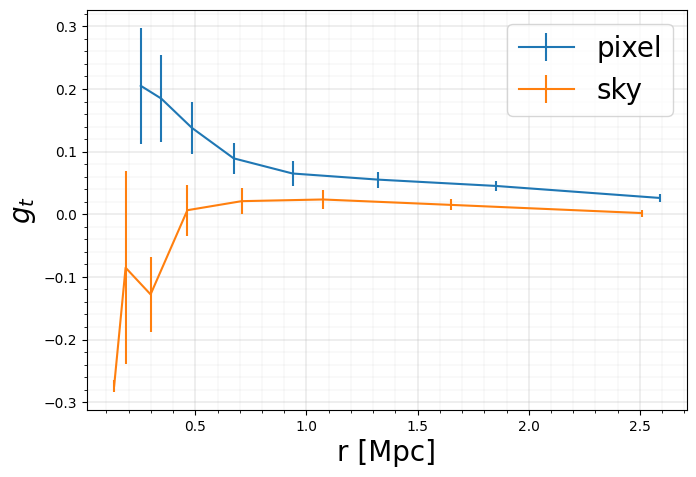

In [16]:
cluster = clmm.GalaxyCluster("Name of cluster", ra_cl, dec_cl, zl, galaxies)

# Convert elipticities into shears for the members.
cluster.compute_tangential_and_cross_components(coordinate_system='pixel')
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    bins=da.make_bins(0.2, 3.0, 8, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)


fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    label='pixel'
)


cluster.compute_tangential_and_cross_components(coordinate_system='sky')
print(cluster.galcat.colnames)

# Measure profile and add profile table to the cluster.
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    bins=da.make_bins(0.1, 3.0, 8, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=True,
)
print(cluster.profile.colnames)

ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["gt"],
    cluster.profile["gt_err"],
    label='sky'
)


ax.set_xlabel("r [Mpc]", fontsize=20)
ax.set_ylabel(r"$g_t$", fontsize=20)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.legend(fontsize=20)
plt.show()

Simplified version of HSC Y3 data (GAMA15H).

In [18]:
clust = np.genfromtxt('./data_coords/mini_GAMA15H/redmapper_dr8_GAMA15H.txt',dtype=np.dtype([('ra',np.float64),('dec',np.float64),('z',np.float64),('richness',np.float64)]))

In [17]:
source = fits.getdata('./data_coords/mini_GAMA15H/GAMA15H_tutorial.fits')

In [19]:
cl = clust[0]

In [20]:
from scipy import spatial
source1 = source[source['photoz']>(cl['z']+0.3)]
tree = spatial.cKDTree(np.array((source1['ra'],source1['dec'])).T)
sel = tree.query_ball_point([cl['ra'],cl['dec']], 3)
bg = source1[sel]

In [21]:
bg

FITS_rec([(210.82153548, -1.50709995, 1.3758055 ,  0.08092293,  0.10835767, 3.90404153, 0.40599512, -0.25950627,  0.00161883,  0.00240663, 0.51526076),
          (210.82056121, -1.50160523, 1.88367689,  0.32586864, -0.48157749, 4.3604162 , 0.40619245, -0.23469312,  0.00020266,  0.00030905, 0.53453451),
          (210.82007918, -1.50101615, 1.50016546, -0.79242778,  0.51766521, 5.15488992, 0.42237528, -0.2440048 , -0.00142779, -0.0021891 , 0.78542656),
          ...,
          (216.26079337,  1.00315502, 0.96254927,  0.31060243,  0.3478314 , 6.60712636, 0.38664818, -0.092641  , -0.00031831,  0.00021643, 0.62135643),
          (216.25910859,  1.00395592, 1.1813668 , -0.26740584,  0.51656026, 4.80835742, 0.44251237, -0.21937594, -0.00162366,  0.00109805, 0.87557292),
          (216.25940093,  1.0079921 , 0.99761593, -0.2840299 ,  0.08879771, 7.09330649, 0.37434303, -0.07929059, -0.00029026,  0.00019429, 0.65537405)],
         dtype=(numpy.record, [('RA', '>f8'), ('Dec', '>f8'), ('photoz',

In [22]:
sources = clmm.GCData(
    [bg['RA'], bg['Dec'], bg['e1'], bg['e2'], bg['photoz'],bg['weight']], names=["ra", "dec", "e1", "e2", "z", "w_ls"]
)

In [23]:
cluster = clmm.GalaxyCluster("redmapper", cl['ra'], cl['dec'], cl['z'], sources)

In [24]:
sigma_c = cosmo.eval_sigma_crit(cl['z'], sources['z'])

In [25]:
cluster.compute_tangential_and_cross_components(
        shape_component1="e1",
        shape_component2="e2",
        tan_component="DS_t",
        cross_component="DS_x",
        cosmo=cosmo,
        is_deltasigma=True,
        use_pdz=False,
        coordinate_system='sky',
    )



(array([0.052344  , 0.05232376, 0.05232771, ..., 0.05231502, 0.05229537,
        0.0523324 ]),
 array([-5.10269837e+14,  3.74729642e+14,  7.93988192e+14, ...,
        -1.85411312e+15, -1.04588999e+15,  3.57887320e+14]),
 array([-8.04914013e+13,  2.12751947e+15, -3.49523009e+15, ...,
         2.15420568e+14, -2.00476291e+15, -1.12910097e+15]))

In [26]:
cluster

ra,dec,e1,e2,z,w_ls,sigma_c,theta,DS_t,DS_x
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
210.8215354813783,-1.50709995286189,0.080922931432724,0.10835766792297363,1.3758054971694946,3.9040415282504566,3819717759154588.0,0.052343996166526664,-510269837472835.9,-80491401304217.47
210.82056121413385,-1.501605229871928,0.3258686363697052,-0.48157748579978943,1.8836768865585327,4.36041620180457,3715185997774635.5,0.052323758939702376,374729641659883.75,2127519469704164.8
210.8200791752013,-1.5010161459837505,-0.7924277782440186,0.5176652073860168,1.5001654624938965,5.154889916819879,3786756084614114.0,0.05232770871949701,793988192157035.8,-3495230088192310.0
210.82082842507086,-1.499351539271592,-0.21478858590126038,-0.2778179943561554,0.8998898267745972,5.397681641813118,4048244596644628.0,0.052304718040591086,1406736556172689.5,205050975125410.06
210.81366421204987,-1.486697530468446,-0.11857343465089798,-0.4502687156200409,1.4502933025360107,4.673579759394774,3799208116450610.5,0.05233868788690602,1503454867834197.0,932166062918862.9
210.82153080389844,-1.4913227048019966,-0.22311601042747498,-0.19615456461906433,1.3474977016448975,4.473369235863828,3828189601580814.0,0.05224111418412021,1136284397081030.2,-47672123899465.78
210.8268651999897,-1.50117481198046,0.31468430161476135,0.7756112813949585,1.4231806993484497,5.364098266327603,3806392172028079.5,0.05221897235809234,-2915819118185433.5,-1284022397943112.5
...,...,...,...,...,...,...,...,...,...
216.25830078968383,1.0008390159148253,0.08721566945314407,-0.07759946584701538,1.5291228294372559,5.637350070496602,3779944379486277.0,0.05225779929062342,49872408193113.38,438443726245903.6


In [27]:
seps = convert_units(cluster.galcat["theta"], "radians", "Mpc", cluster.z, cosmo)

cluster.make_radial_profile(
    tan_component_in="DS_t",
    cross_component_in="DS_x",
    tan_component_out="DS_t",
    cross_component_out="DS_x",
    weights_in="w_ls",
    bins=da.make_bins(0.1, 20.0, 15, method="evenlog10width"),
    bin_units="Mpc",
    cosmo=cosmo,
    include_empty_bins=False,
    gal_ids_in_bins=False,
)
print(cluster.profile.colnames)



['radius_min', 'radius', 'radius_max', 'DS_t', 'DS_t_err', 'DS_x', 'DS_x_err', 'z', 'z_err', 'n_src', 'W_l']


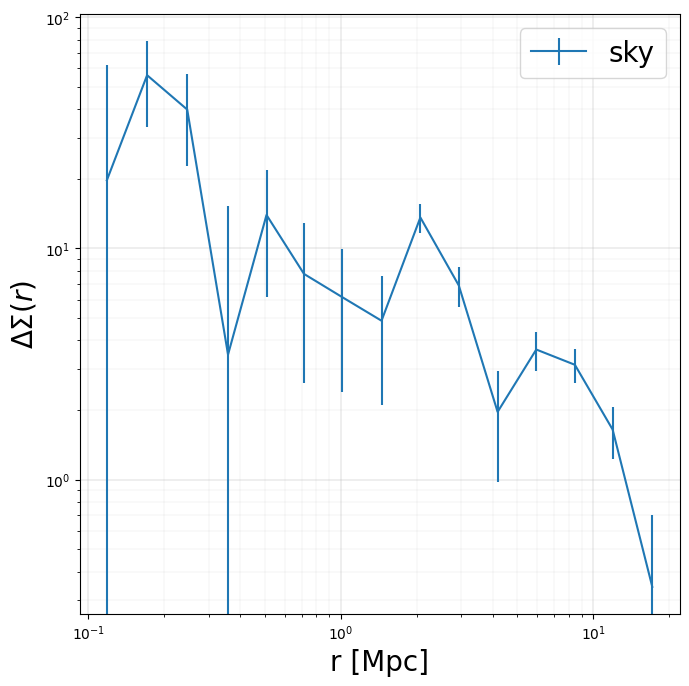

<Figure size 640x480 with 0 Axes>

In [28]:

fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes((0, 0, 1, 1))
errorbar_kwargs = dict(linestyle="", marker="o", markersize=1, elinewidth=0.5, capthick=0.5)
ax.errorbar(
    cluster.profile["radius"],
    cluster.profile["DS_t"]/ 1e13,
    cluster.profile["DS_t_err"]/1e13,
    label='sky'
)
plt.loglog()

ax.set_xlabel("r [Mpc]", fontsize=20)
ax.set_ylabel(r"$\Delta\Sigma(r)$", fontsize=20)
ax.grid(lw=0.3)
ax.minorticks_on()
ax.grid(which="minor", lw=0.1)
plt.legend(fontsize=20)
plt.show()
plt.savefig('clmm_hsc_cluster.png')


Measuring the lensing signal without using CLMM.

In [29]:
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import spatial
from colossus.cosmology import cosmology

In [34]:
clust = np.genfromtxt('./data_coords/mini_GAMA15H/redmapper_dr8_GAMA15H.txt',dtype=np.dtype([('RA',np.float64),('Dec',np.float64),('z',np.float64),('richness',np.float64)]))
source = fits.getdata('./data_coords/mini_GAMA15H/GAMA15H_tutorial.fits')

In [35]:
cosmo = cosmology.setCosmology('planck18')

In [36]:
#Define a function to compute the angle between lens and source galaxies
def calcDistanceAngle(a1, d1, a2, d2):
    return np.arccos(np.cos(d1)*np.cos(d2)*np.cos(a1-a2)+np.sin(d1)*np.sin(d2))

#Define a function to compute the cos(2phi) and sin(2phi) between lens and source galaxies
def cosPhi2(a1, a2, d1, d2, distanceAngle):
    return np.sin(a2 - a1)*np.cos(d1)/np.sin(distanceAngle)

def sinPhi2(a1, a2, d1, d2, distanceAngle):
    return (-np.cos(d2)*np.sin(d1) + np.sin(d2)*np.cos(d1)*np.cos(a1-a2))/np.sin(distanceAngle)

In [37]:
#TS: This is a simplified way to measure lensing signals (without worrying about resposivity, multiplicative and additive biases)
d2r = np.pi/180.
r2d = 180./np.pi
Mpc = 3.08568025*10**19 # 1Mpc = 3.08568025*10**19 km                                                                                                    
M_sun = 1.9884*10**33 # solar mass [g]  
c_light = 2.99792458*10**5 # speed of light [km/s] 
G = 6.67384*10**(-20)# gravitational constant [km^3s^-2kg^-1] 
Sigma_cr_fact = c_light**2/(4*np.pi*G)*Mpc*10**3/M_sun
bin_edges = np.logspace(-1,np.log10(20),15)#Define your radial bins

sum = np.rec.fromarrays((np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1),
                         np.zeros(len(bin_edges)-1)),
                         names = ("e_sq", "w", "wetsigma", "wetsigma_sq", "wexsigma", "wexsigma_sq", "wsigmainv", "wzs", "n"))


#Calculate tangential shear for each lens
#Select lens clusters: selecting many will take time to compute...
source1 = source[source['photoz']>0.5]
tree = spatial.cKDTree(np.array((source1['RA'],source1['Dec'])).T)


source2 = source[(source['photoz']<1.0)&(source['photoz']>0.9)]
tree = spatial.cKDTree(np.array((source1['RA'],source1['Dec'])).T)
l = clust[(clust['z']>0.1)&(clust['z']<0.2)][:1]  
print(l.size)
l_weight = np.ones(l.size) #Weights for the cluster lenses are one

for i in np.arange(l.size):

    #Select source galaxies
    sel = tree.query_ball_point([l['RA'][i],l['Dec'][i]], 3)
    sel_z = source[sel]['photoz']>l['z'][i] #Try to change the source galaxy selection
    source_bg = source[sel][sel_z]
    theta = calcDistanceAngle(l['RA'][i]*d2r, l['Dec'][i]*d2r, source_bg['RA']*d2r, source_bg['Dec']*d2r)  #Compute an angle between the lens and the source
    l_chi =  cosmo.comovingDistance(z_min=0.0,z_max=l['z'][i])#Compute the comoving distance of the lens
    r = theta*l_chi                                                                                                 
    assign_r = np.digitize(r, bin_edges)


    for i_r in range(len(bin_edges)-1):
        #print i_r                                                                                                                               
        sel = assign_r == i_r+1
        source_bg_inbin = source_bg[sel]
        theta_sub = theta[sel]
        cosp = cosPhi2(l["RA"][i]*d2r, source_bg_inbin["RA"]*d2r, l["Dec"][i]*d2r, source_bg_inbin["Dec"]*d2r, theta_sub)
        sinp = sinPhi2(l["RA"][i]*d2r, source_bg_inbin["RA"]*d2r, l["Dec"][i]*d2r, source_bg_inbin["Dec"]*d2r, theta_sub)
        cos2p = cosp**2 - sinp**2
        sin2p = 2.*sinp*cosp
        et = -(source_bg_inbin["e1"]*cos2p+source_bg_inbin["e2"]*sin2p)
        ex = -(-source_bg_inbin["e1"]*sin2p+source_bg_inbin["e2"]*cos2p)
        # critical surface mass density [M_sun/ comoving Mpc^2]. (1+zl)**-2 is for comoving coordinates.  
        Sigma_cr = Sigma_cr_fact/(1. - l_chi/cosmo.comovingDistance(z_min=0.0,z_max=source_bg_inbin["photoz"]))/l_chi/(1.+l["z"][i])/10**12  
                              
        sum["n"][i_r] += sel.sum()
                              
        sum["e_sq"][i_r] += np.sum(et**2 + ex**2)
        wt = source_bg_inbin["weight"]*Sigma_cr**-2 #multiply by the lens weights if it is not one
        sum["w"][i_r] += np.sum(wt)
        wetsigma = wt*Sigma_cr*et
        sum["wetsigma"][i_r] += np.sum(wetsigma)
        sum["wetsigma_sq"][i_r] += np.sum(wetsigma**2)
        wexsigma = wt*Sigma_cr*ex
        sum["wexsigma"][i_r] += np.sum(wexsigma)
        sum["wexsigma_sq"][i_r] += np.sum(wexsigma**2)
        wsigmainv = wt*1./Sigma_cr
        sum["wsigmainv"][i_r] += np.sum(wsigmainv)
        wzs = wt*source_bg_inbin["photoz"]
        sum["wzs"][i_r] += np.sum(wzs)

1


In [38]:
#Compute the lensing signal            
radial_bin = 2.*(bin_edges[1:]**3 - bin_edges[:-1]**3)/(3.*(bin_edges[1:]**2 - bin_edges[:-1]**2))
gt = 0.5*sum["wetsigma"]/sum["w"]
gt_err = 0.5*np.sqrt(sum["wetsigma_sq"])/sum["w"]
gx = 0.5*sum["wexsigma"]/sum["w"]
gx_err = 0.5*np.sqrt(sum["wexsigma_sq"])/sum["w"]
sigma_cr = 1./(sum["wsigmainv"]/sum["w"])

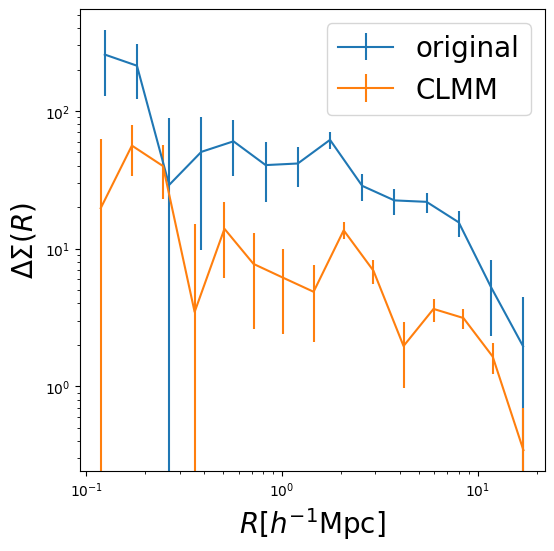

In [39]:
#Figure for the lensing signal
plt.figure(figsize=(6,6))
plt.errorbar(radial_bin,gt,yerr=gt_err,label='original')
plt.errorbar(
    cluster.profile["radius"],
    cluster.profile["DS_t"]/ 1e13,
    cluster.profile["DS_t_err"]/1e13,
    label='CLMM'
)
plt.loglog()
plt.legend(fontsize=20)
plt.xlabel(r'$R[h^{-1}{\rm Mpc}]$',fontsize=20)
plt.ylabel(r'$\Delta\Sigma(R)$',fontsize=20)
plt.savefig('weaklens_hsc_clust.png')